In [1]:
from utils.all import *
from scipy.stats import kendalltau
from evaluate import load

sari = load("sari")
data = load_data('../annotated', batch_num=[1, 2], preprocess=True)

Loading files: ['../annotated/batch_1_anton.json', '../annotated/batch_1_ayush.json', '../annotated/batch_1_kelly.json', '../annotated/batch_2_vinayak.json', '../annotated/batch_2_vishnesh.json']

Found users: {'kelly', 'ayush', 'anton', 'vinayak', 'vishnesh'}



In [9]:
# Gets parameters for only a certain family of edits
def get_params(op):
    curr_params = default_params.copy()
    params_consider = []
    # Consider only:
    if (op == 'content'):
        # Content edits
        params_consider = [
            'good_deletion',
            'good_insertion',
            'content_error'
        ]
    elif (op == 'syntax'):
        # Syntax edits
        params_consider = [
            'good_syntax'
        ]
    elif (op == 'lexical'):
        # Lexical edits
        params_consider = [
            'good_paraphrase',
            'good_trivial_insertion',
            'grammar_error'
        ]

        # Content quality edits
        # Content error edits
        # Syntax quality edits
        # Syntax error edits
        # Lexical quality edits
        # Lexical error edits

    elif (op == 'quality'):
        # Only quality edits
        params_consider = [
            'good_insertion',
            'good_deletion',
            'good_paraphrase',
            'good_trivial_insertion', 
            'good_syntax'
        ]
    elif (op == 'error'):
        # Only error edits
        params_consider = [
            'content_error',
            'grammar_error'
        ]

    params_consider += ['size_calculation']

    for param in curr_params.keys():
        if param not in params_consider:
            curr_params[param] = 0
    
    return curr_params

In [8]:
# Get 5 sentence scores considering only content edits
[x['score'] for x in calculate_sentence_scores(data, get_params('content'))][:5]

[0.0,
 7.981956423567116,
 1.995489105891779,
 5.272384733203716,
 11.258852050879053]

In [9]:
# Get sentences where at least 1 annotator identified an error
error = Error.CONTRADICTION
out_sents = set()
for sent in data:
    for ann in sent['processed_annotations']:
        if ann['error_type'] == error:
            out_sents.add((sent['original'], sent['system']))
out = []
for orig in out_sents:
    out.append([x for x in data if x['original'] == orig[0] and x['system'] == orig[1]])

In [ ]:
# Get all sentences where at least 1 annotator identified an error of that type

# Content Errors	
# 	Coreference
# 	Information Rewrite
# 	Repeititon
# 	Contradiction
# 	Hallucination
# 	Irrelevant
# Syntax Errors	
# 	Syntax Error
# Lexical Errors	
# 	Unnecessary Insertion
# 	Complex Wording
# 	Grammar Error

In [25]:
# Calculate the SARI score for all unique sentences
# For each sentence, we have 5 generations and 3 annotations per generation
# Of the 5 generations, 2 are ASSET human references, 1 is TurkCorpus human reference

scores = []
for orig in set([x['original'] for x in data]):
    sents = [x for x in data if x['original'] == orig]

    asset = [x for x in sents if 'asset' in x['system']]
    t5 = [x for x in sents if 'T5' in x['system']][0]

    # Take the SARI score for T5, our best generation with the 2 ASSET human references
    references = [x['simplified'] for x in asset]
    prediction = t5['simplified']
    
    simpeval_score = t5['simpeval_scores']
    if simpeval_score is None:
        continue
    simpeval_score = avg(simpeval_score)

    our_score = t5['score']

    score = {
        'original': orig,
        'simplified': prediction,
        'system': t5['system'],
        'sari': sari_score,
        'simpeval': simpeval_score,
        'our_score': our_score
    }

    # The next goal is to calculate a bunch of variations on our score considering only
    # certain dimensions of the metric
    for condition in ['content', 'syntax', 'lexical', 'quality', 'error']:
        score[f'our_score_{condition}'] = calculate_sentence_score(t5, get_params(condition))

    # Then we can calculate more complex automatic metrics like BERTScore, COMET

    sari_score = sari.compute(sources=[orig], predictions=[prediction], references=[references])['sari']

    scores.append(score)

scores[0]

{'original': 'In return, Rollo swore fealty to Charles, converted to Christianity, and undertook to defend the northern region of France against the incursions of other Viking groups.',
 'simplified': 'In return, Rollo swore loyalty to Charles and converted to Christianity. || He also said he would defend the northern part of France against other Viking groups.',
 'system': 'systems/T5.txt',
 'sari': 55.226606843090146,
 'simpeval': 1.28,
 'our_score': 3.721647211492401,
 'our_score_content': 2.1161909551258598,
 'our_score_syntax': 0.0,
 'our_score_lexical': 1.605456256366541,
 'our_score_quality': 3.721647211492401,
 'our_score_error': 0.0}

In [34]:
for system in ['sari', 'simpeval']:
    print(system)
    for condition in ['content', 'syntax', 'lexical', 'quality', 'error']:
        corr = kendalltau([s[f'our_score_{condition}'] for s in scores], [s[system] for s in scores]).correlation
        print(round(corr, 4))

sari
-0.0118
0.0448
-0.1488
0.1579
0.0818
simpeval
0.0888
-0.0577
-0.0358
0.176
-0.1913


In [35]:
len(scores)

19

In [ ]:
# The problem with BERTScore is my verion of PyTorch is
# incompatible with their library, I'll have to use a virtual
# environment to get it to work.

# from bert_score import score

# with open("bert_score/example/hyps.txt") as f:
#     cands = [line.strip() for line in f]

# with open("bert_score/example/refs.txt") as f:
#     refs = [line.strip() for line in f]

# P, R, F1 = score(cands, refs, lang="en", verbose=True)

# print(f"System level F1 score: {F1.mean():.3f}")

In [ ]:
# import comet
# They have a python library but it doesn't work great...

# !echo -e "Dem Feuer konnte Einhalt geboten werden\nSchulen und Kindergärten wurden eröffnet." >> comet/src.de
# !echo -e "The fire could be stopped\nSchools and kindergartens were open" >> comet/hyp1.en
# !echo -e "The fire could have been stopped\nSchools and pre-school were open" >> comet/hyp2.en
# !echo -e "They were able to control the fire.\nSchools and kindergartens opened" >> comet/ref.en

# !comet-score -s comet/src.de -t comet/hyp1.en -r comet/ref.en

In [ ]:
# One of the COMET scores worth looking at:
# wmt21-comet-mqm: This model was pre-trained on Direct Assessments from WMT15 to WMT20 and then fine-tuned on MQM z-scores from Freitag et al, 2021 (MQM). This model was one of the best performing metrics that year [Freitag et al. 2021 (WMT21)].

### Edit Reversing

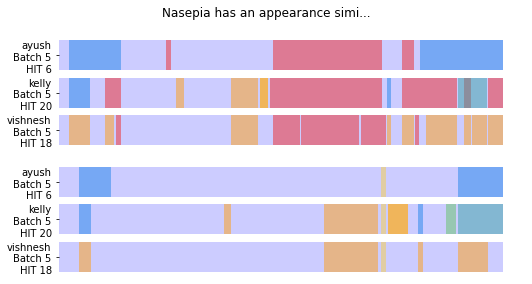

In [ ]:
from graphs import *

id_ = 40
sents = [sent for sent in data if sent['id'] == id_]
draw_agreement(sents)

In [ ]:
# Problems with reversing edits:
    # Overlapping edits (of different types)
    # Deletions have no mapping to the original sentence
    # Re-orders have no mapping to their original location

In [ ]:
# My approach
    # use generate_token_dict(s) to get a list of token spans for the input/output
    # iterate through edits (in some predetermined priority order) to list the operations we perform on each word
    # perform those operations to collapse the sentence

In [ ]:
s = sents[0]
orig = s['original']
simp = s['simplified']

In [ ]:
generate_token_dict(orig)

{(0, 2): {},
 (3, 10): {},
 (11, 16): {},
 (17, 22): {},
 (23, 29): {},
 (30, 32): {},
 (33, 41): {},
 (42, 51): {},
 (52, 54): {},
 (55, 68): {},
 (69, 72): {},
 (73, 82): {},
 (83, 85): {},
 (86, 92): {},
 (93, 96): {},
 (97, 105): {},
 (106, 112): {},
 (113, 115): {},
 (116, 122): {},
 (123, 130): {},
 (131, 134): {},
 (135, 145): {},
 (146, 148): {},
 (149, 154): {},
 (155, 161): {},
 (162, 169): {}}